# Analysis of refrigerant-ethanol saturated vapour pressure measurements

Data collected by Swetha Vutlapalli - 2023

    
    @author Daniel Duke <daniel.duke@monash.edu>
    @copyright (c) 2023 LTRAC
    @license GPL-3.0+
    @version 0.0.1
    @date 24/02/2023
        __   ____________    ___    ______
       / /  /_  ____ __  \  /   |  / ____/
      / /    / /   / /_/ / / /| | / /
     / /___ / /   / _, _/ / ___ |/ /_________
    /_____//_/   /_/ |__\/_/  |_|\__________/

    Laboratory for Turbulence Research in Aerospace & Combustion (LTRAC)
    Monash University, Australia

    This program is free software: you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.

    You should have received a copy of the GNU General Public License
    along with this program.  If not, see <https://www.gnu.org/licenses/>.

In [5]:
# Load required modules
import numpy as np
import scipy.optimize, scipy.integrate, scipy.interpolate
import matplotlib.pyplot as plt
%matplotlib notebook

The data copied here from the spreadsheets have already been extracted from timeseries as the equilibrium conditions.

`Canister_Tcal_degC` is the bath temperature measured by RTD near the canister wall, in degrees C.

`Pressure_bar_abs` is the absolute pressure at the pressure transducer outside the bath.

`PressureTxTemp_degC` is the temperature at the pressure transducer (close to room temperature).

`NIST_Temp_degC` is the NIST REFPROP temperature of pure propellant at the pressure `Pressure_bar_abs`.

## Step 1. Check pure propellant data for any required corrections

First, let's load a plot the data obtained from experiments against NIST data. We use the measured pressure to look up the expected saturation temperature. Pascal's law requires the pressure at the transducer to deviate from the saturation pressure inside the can by no more than

$ P - \rho_v g \Delta h $ 

which for these experiments will be on the order of 10 Pa, or 0.0001 bar -- far smaller than the precision of our sensor. So pressure bias will only be due to sensor error.

If the pressure sensor is well calibrated, deviations between NIST and experiment will primarily be due to _temperature drift_ i.e. one end of the closed system is at room temp and the other is at the bath temp, and this sets up a temperature gradient giving a small change in the average temperature. We expect that the temperature will be 'too high' when below room temp, and 'too low' when above room temp if this is the case. There can also be *hysteresis*; sudden jumps in the signal when the direction of heat flow changes or exceeds a certain value.

In [156]:
# From Excel: R152_data.xlsx Sheet E0_ R152a (Abs. Transducer)
HFA152a_E0A = {'Canister_Tcal_degC':np.array([52.57572167,47.50266015,42.49312543,37.50198775,32.50150759,27.49301665,22.40212251,17.39894866,12.2667684,7.162201723,2.007622342,-2.620682715,-7.507531664,-12.73091152,-17.8730646,-25.66495233,-33.8375149,-46.06863721]),\
              'Pressure_bar_abs':np.array([12.31401093,10.84006898,9.537076399,8.346442156,7.271541578,6.344051768,5.554963806,4.786223815,3.971836751,3.399220836,2.888719428,2.480584312,2.103013446,1.768236418,1.466668006,1.134602181,0.856330984,0.560450771]),\
              'PressureTxTemp_degC':np.array([21.75357388,21.66452113,21.65967504,21.40394908,21.88688369,22.13289817,22.50123228,21.92886689,21.59239734,21.82841597,21.89118436,21.71908785,21.4909228,21.3992574,20.86355092,20.9644198,20.96482596,20.3047787]),\
              'NIST_Temp_degC':np.array([51.803,46.732,41.798,36.826,31.856,27.101,22.622,17.767,11.928,7.248,2.534,-1.7211,-6.1707,-10.67,-15.333,-21.436,-27.757,-36.62]),\
              'EthanolFraction':0}

# From Excel: R152_data.xlsx Sheet E0_ R152a (Gauge Transducer)
HFA152a_E0G = {'Canister_Tcal_degC':np.array([48.8848414,44.01226842,39.95056592,34.25869398,29.3190617,24.40861938,19.41601687,14.49854318,9.608204626,4.561030461,-0.634246118,-5.818212433,-10.9971881,-16.12671794,-21.43460601,-31.81816993,-31.73930286]),\
              'Pressure_bar_abs':np.array([11.14451386,9.959257584,8.805471772,7.766803894,6.883583113,6.243091766,5.628263117,5.152465472,4.769877463,4.186257481,3.657985532,3.202304232,2.804494491,2.450459986,2.154351933,1.690152524,1.619884065]),\
              'PressureTxTemp_degC':np.array([20.60156027,20.43746945,20.47060608,20.71326277,20.70765698,20.98216756,21.24689863,21.55858422,22.64608025,22.47152675,22.34566299,22.09353573,22.11604625,20.67586619,20.76511243,22.69120437,21.47662322]),\
              'NIST_Temp_degC':np.array([47.82,43.449,38.803,34.21,29.926,26.552,23.057,20.148,17.658,13.548,9.4323,5.4986,1.6958,-2.056,-5.531,-11.813,-12.879]),\
              'EthanolFraction':0}

# From Excel: R1234_data.xlsx sheet E0_Abs
HFO1234_E0A = {'Canister_Tcal_degC':np.array([50.42424128,45.3579576,40.37284869,35.33388687,30.27645651,25.25014253,20.05670481,15.00820146,9.916052654,4.805107097,-0.32836189,-5.438458582,-10.65343371,-15.78068035,-21.10803456,-31.23532025,-36.15046224]),\
              'Pressure_bar_abs':np.array([9.82922241,8.607314639,7.521649068,6.536222659,5.64783779,4.855120142,4.129371814,3.54571022,2.985239491,2.493972813,2.062242691,1.690439851,1.369027114,1.097896291,0.866413188,0.55179743,0.440811029]),\
              'PressureTxTemp_degC':np.array([22.93343744,23.11644592,23.19205541,22.65905557,22.41673411,22.20958985,20.92563378,20.79681498,20.832199,20.66205291,21.02035058,21.93125125,21.66326656,21.10134526,20.49236489,22.99092962,20.57125824]),\
              'NIST_Temp_degC':np.array([49.434,44.327,39.31,34.26,29.19,24.129,18.912,14.185,9.0485,3.898,-1.3194,-6.5405,-11.832,-17.114,-22.51,-32.084,-36.535]),\
              'EthanolFraction':0}

# From Excel: R1234_data.xlsx sheet E0_Gauge
HFO1234_E0G = {'Canister_Tcal_degC':np.array([47.79029443,43.09544947,38.37098082,33.50201449,28.74711201,23.91020363,19.02855507,14.20818349,9.204952047,4.22556571,-10.94752157,-21.38336195,-32.38342561]),\
              'Pressure_bar_abs':np.array([9.1291929,8.046869596,7.07583776,6.173347135,5.376114411,4.645837118,3.98395386,3.399999984,2.869414322,2.361775263,1.318504826,0.84758743,0.521845577]),\
              'PressureTxTemp_degC':np.array([19.98814352,19.96897854,19.87192322,19.95127517,19.88007723,19.96211754,20.08030928,20.012007,20.08763725,20.0513903,20.37394701,20.53897198,21.19815183]),\
              'NIST_Temp_degC':np.array([46.571,41.801,37.091,32.256,27.519,22.689,17.784,12.913,7.8963,2.3797,-12.749,-22.997,-33.209]),\
              'EthanolFraction':0}

# From Excel: DDL_SVP_Data.xlsx sheet Data_R134a
HFA134a_E0 = {'Canister_Tcal_degC':np.array([54.276,49.952,45.723,41.455,37.204,32.922,30.715,26.700,23.036,20.977,18.352,15.280,11.927,8.907,4.839,0.819]),\
              'Pressure_bar_abs':np.array([13.915,12.578,11.376,10.279,9.604,8.665,8.198,7.394,6.763,6.474,6.222,5.726,5.198,4.789,4.290,3.839]),\
              'PressureTxTemp_degC':np.array([23.582,23.497,23.152,22.586,24.871,24.647,24.225,23.009,21.067,19.974,23.751,23.920,21.293,21.326,20.711,20.539]),\
              'NIST_Temp_degC':np.array([52.176,48.152,44.252,40.413,37.896,34.162,32.190,28.588,25.549,24.082,22.769,20.050,16.954,14.391,11.024,7.718]),\
              'EthanolFraction':0}

<IPython.core.display.Javascript object>


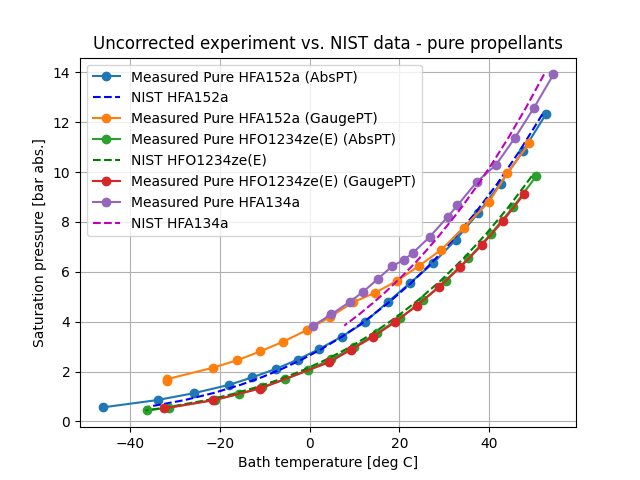

In [158]:
fig=plt.figure()
plt.title("Uncorrected experiment vs. NIST data - pure propellants")
plt.grid(); plt.xlabel('Bath temperature [deg C]'); plt.ylabel('Saturation pressure [bar abs.]')

plt.plot(HFA152a_E0A['Canister_Tcal_degC'], HFA152a_E0A['Pressure_bar_abs'],marker='o',label='Measured Pure HFA152a (AbsPT)')
plt.plot(HFA152a_E0A['NIST_Temp_degC'], HFA152a_E0A['Pressure_bar_abs'],label='NIST HFA152a',ls='--',c='b')
plt.plot(HFA152a_E0G['Canister_Tcal_degC'], HFA152a_E0G['Pressure_bar_abs'],marker='o',label='Measured Pure HFA152a (GaugePT)')

plt.plot(HFO1234_E0A['Canister_Tcal_degC'], HFO1234_E0A['Pressure_bar_abs'],marker='o',label='Measured Pure HFO1234ze(E) (AbsPT)')
plt.plot(HFO1234_E0['NIST_Temp_degC'], HFO1234_E0['Pressure_bar_abs'],label='NIST HFO1234ze(E)',ls='--',c='g')
plt.plot(HFO1234_E0G['Canister_Tcal_degC'], HFO1234_E0G['Pressure_bar_abs'],marker='o',label='Measured Pure HFO1234ze(E) (GaugePT)')

plt.plot(HFA134a_E0['Canister_Tcal_degC'], HFA134a_E0['Pressure_bar_abs'],marker='o',label='Measured Pure HFA134a')
plt.plot(HFA134a_E0['NIST_Temp_degC'], HFA134a_E0['Pressure_bar_abs'],label='NIST HFA134a',ls='--',c='m')
plt.legend();

The above result is close to expected. The temperature error, while small, gets larger and positive at higher temperatures. 

Result for HFA-152a and HFO-1234ze(E) is good . Result for HFA-134(a) may need more careful check.

## 2. Develop a correction function for the temperature deviation

The correction will likely need to increase somewhat proportionally to the difference between the temperature in the bath and at the pressure transducer (ie the magnitude of the gradient in temperature). Let's plot the error between NIST and measured temperature against the temperature gradient in the system.

<IPython.core.display.Javascript object>


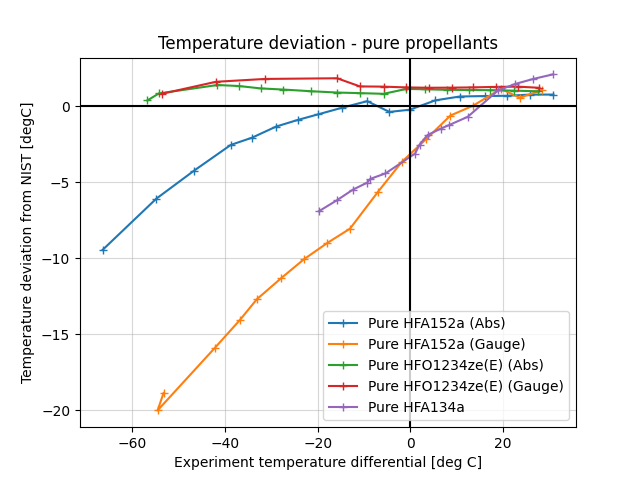

In [166]:
# Compute differences

Tdiff_152aA = HFA152a_E0A['Canister_Tcal_degC']-HFA152a_E0A['PressureTxTemp_degC']
Tdev_152aA =  HFA152a_E0A['Canister_Tcal_degC']-HFA152a_E0A['NIST_Temp_degC']

Tdiff_152aG = HFA152a_E0G['Canister_Tcal_degC']-HFA152a_E0G['PressureTxTemp_degC']
Tdev_152aG =  HFA152a_E0G['Canister_Tcal_degC']-HFA152a_E0G['NIST_Temp_degC']

Tdiff_1234zeA = HFO1234_E0A['Canister_Tcal_degC']-HFO1234_E0A['PressureTxTemp_degC']
Tdev_1234zeA = HFO1234_E0A['Canister_Tcal_degC']-HFO1234_E0A['NIST_Temp_degC']

Tdiff_1234zeG = HFO1234_E0G['Canister_Tcal_degC']-HFO1234_E0G['PressureTxTemp_degC']
Tdev_1234zeG = HFO1234_E0G['Canister_Tcal_degC']-HFO1234_E0G['NIST_Temp_degC']

Tdiff_134a = HFA134a_E0['Canister_Tcal_degC']-HFA134a_E0['PressureTxTemp_degC']
Tdev_134a = HFA134a_E0['Canister_Tcal_degC']-HFA134a_E0['NIST_Temp_degC']

# Make graph
fig=plt.figure()
plt.title("Temperature deviation - pure propellants")
plt.grid(alpha=.5); plt.xlabel('Experiment temperature differential [deg C]')
plt.ylabel('Temperature deviation from NIST [degC]')
plt.plot(Tdiff_152aA, Tdev_152aA ,marker='+',label='Pure HFA152a (Abs)')
plt.plot(Tdiff_152aG, Tdev_152aG ,marker='+',label='Pure HFA152a (Gauge)')
plt.plot(Tdiff_1234zeA, Tdev_1234zeA,marker='+',label='Pure HFO1234ze(E) (Abs)')
plt.plot(Tdiff_1234zeG, Tdev_1234zeG,marker='+',label='Pure HFO1234ze(E) (Gauge)')
plt.plot(Tdiff_134a, Tdev_134a,marker='+',label='Pure HFA134a')
plt.axvline(0,c='k'); plt.axhline(0,c='k')
plt.legend();

Let's try and fit a function to these curves that accounts for the hysteresis (discontinuity) that can occur near differential of 0 degrees (ie. where the temperature gradient from one end of the pipe to the other changes direction, and thus the magnitude of the thermal conductivity might change.

<IPython.core.display.Javascript object>


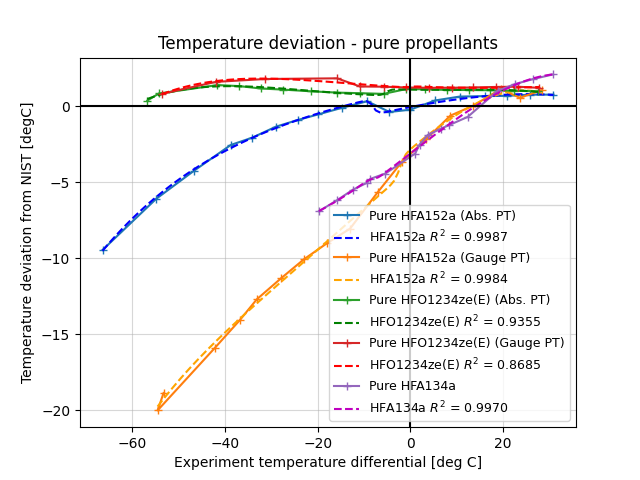

In [168]:
# An empirical function I made up.
def temperatureCorrectionFunction(Tdiff, a, b, c, d, e, dT1, dT0):

    # guardrails
    if c==0: c+=1e-6
    if dT1==0: dT1=1e-2
    dT2=1.0
    
    #a=0
    linearCorrection = a*Tdiff**4 + b*Tdiff**3 + c*Tdiff**2 + d*Tdiff + e
    
    nonlinearCorrection = -dT1*(np.tanh(dT2*(Tdiff+np.abs(dT0)))*0.5 + 0.5)
    
    return linearCorrection + nonlinearCorrection

# Calculate R-squared.
def calcR2(f, xdata, ydata, popt):
    residuals = ydata- f(xdata, *popt)
    ss_tot = np.sum((ydata-np.mean(ydata))**2)
    return 1 - (np.nansum(residuals**2) / ss_tot)

# Run curve fitting (least squares)
popt1A, pcov1A = scipy.optimize.curve_fit(temperatureCorrectionFunction,Tdiff_152aA,Tdev_152aA)
r2_1A = calcR2(temperatureCorrectionFunction,Tdiff_152aA,Tdev_152aA,popt1A)
Td1A = np.linspace(Tdiff_152aA.min(),Tdiff_152aA.max(),100)

popt1G, pcov1G = scipy.optimize.curve_fit(temperatureCorrectionFunction,Tdiff_152aG,Tdev_152aG)
r2_1G = calcR2(temperatureCorrectionFunction,Tdiff_152aG,Tdev_152aG,popt1G)
Td1G = np.linspace(Tdiff_152aG.min(),Tdiff_152aG.max(),100)

popt2A, pcov2A = scipy.optimize.curve_fit(temperatureCorrectionFunction,Tdiff_1234zeA,Tdev_1234zeA)
r2_2A = calcR2(temperatureCorrectionFunction,Tdiff_1234zeA,Tdev_1234zeA,popt2A)
Td2A = np.linspace(Tdiff_1234zeA.min(),Tdiff_1234zeA.max(),100)

popt2G, pcov2G = scipy.optimize.curve_fit(temperatureCorrectionFunction,Tdiff_1234zeG,Tdev_1234zeG)
r2_2G = calcR2(temperatureCorrectionFunction,Tdiff_1234zeG,Tdev_1234zeG,popt2G)
Td2G = np.linspace(Tdiff_1234zeG.min(),Tdiff_1234zeG.max(),100)

popt3, pcov3 = scipy.optimize.curve_fit(temperatureCorrectionFunction,Tdiff_134a,Tdev_134a)
r2_3 = calcR2(temperatureCorrectionFunction,Tdiff_134a,Tdev_134a,popt3)
Td3 = np.linspace(Tdiff_134a.min(),Tdiff_134a.max(),100)


fig=plt.figure()
plt.title("Temperature deviation - pure propellants")
plt.grid(alpha=.5); plt.xlabel('Experiment temperature differential [deg C]'); plt.ylabel('Temperature deviation from NIST [degC]')

plt.plot(Tdiff_152aA, Tdev_152aA ,marker='+',label='Pure HFA152a (Abs. PT)')
plt.plot(Td1A, temperatureCorrectionFunction(Td1A, *popt1A), ls='--',c='b',label='HFA152a $R^2$ = %.4f' % r2_1A)

plt.plot(Tdiff_152aG, Tdev_152aG ,marker='+',label='Pure HFA152a (Gauge PT)')
plt.plot(Td1G, temperatureCorrectionFunction(Td1G, *popt1G), ls='--',c='orange',label='HFA152a $R^2$ = %.4f' % r2_1G)

plt.plot(Tdiff_1234zeA, Tdev_1234zeA,marker='+',label='Pure HFO1234ze(E) (Abs. PT)')
plt.plot(Td2A, temperatureCorrectionFunction(Td2A, *popt2A), ls='--',c='g',label='HFO1234ze(E) $R^2$ = %.4f' % r2_2A)

plt.plot(Tdiff_1234zeG, Tdev_1234zeG,marker='+',label='Pure HFO1234ze(E) (Gauge PT)')
plt.plot(Td2G, temperatureCorrectionFunction(Td2G, *popt2G), ls='--',c='r',label='HFO1234ze(E) $R^2$ = %.4f' % r2_2G)

plt.plot(Tdiff_134a, Tdev_134a,marker='+',label='Pure HFA134a')
plt.plot(Td3, temperatureCorrectionFunction(Td3, *popt3), ls='--',c='m',label='HFA134a $R^2$ = %.4f' % r2_3)

plt.axvline(0,c='k'); plt.axhline(0,c='k')
plt.legend(fontsize=9);

Now plot again with the correction function applied:

<IPython.core.display.Javascript object>


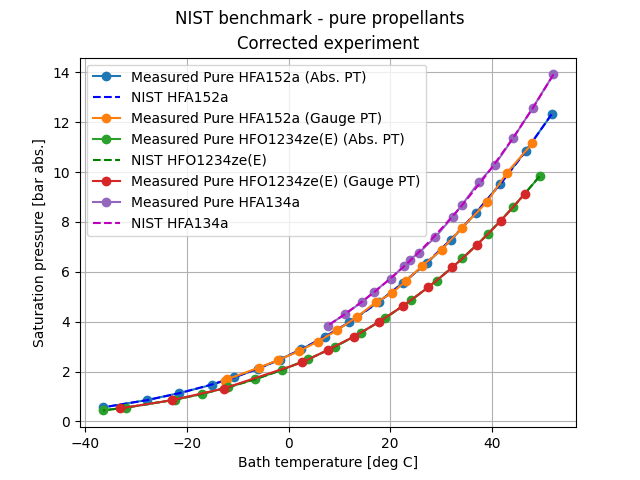

In [170]:
fig=plt.figure()
plt.suptitle("NIST benchmark - pure propellants")

# Note that Tdiff_152a is the same data point as plotted here, so no need to recalculate temperature differential.
# If using on other dataset ie ethanol-containing mixture, would need to recalc Tdiff.
ax=fig.add_subplot(111)
plt.title("Corrected experiment")
plt.grid(); plt.xlabel('Bath temperature [deg C]'); plt.ylabel('Saturation pressure [bar abs.]')

ax.plot(HFA152a_E0A['Canister_Tcal_degC']-temperatureCorrectionFunction(Tdiff_152aA,*popt1A),\
            HFA152a_E0A['Pressure_bar_abs'],marker='o',label='Measured Pure HFA152a (Abs. PT)')

ax.plot(HFA152a_E0['NIST_Temp_degC'], HFA152a_E0['Pressure_bar_abs'],label='NIST HFA152a',ls='--',c='b')

ax.plot(HFA152a_E0B['Canister_Tcal_degC']-temperatureCorrectionFunction(Tdiff_152aG,*popt1G),\
            HFA152a_E0B['Pressure_bar_abs'],marker='o',label='Measured Pure HFA152a (Gauge PT)')


ax.plot(HFO1234_E0A['Canister_Tcal_degC']-temperatureCorrectionFunction(Tdiff_1234zeA,*popt2A),\
        HFO1234_E0A['Pressure_bar_abs'],marker='o',label='Measured Pure HFO1234ze(E) (Abs. PT)')

ax.plot(HFO1234_E0A['NIST_Temp_degC'], HFO1234_E0A['Pressure_bar_abs'],label='NIST HFO1234ze(E)',ls='--',c='g')

ax.plot(HFO1234_E0G['Canister_Tcal_degC']-temperatureCorrectionFunction(Tdiff_1234zeG,*popt2G),\
        HFO1234_E0G['Pressure_bar_abs'],marker='o',label='Measured Pure HFO1234ze(E) (Gauge PT)')

ax.plot(HFA134a_E0['Canister_Tcal_degC']-temperatureCorrectionFunction(Tdiff_134a,*popt3),\
        HFA134a_E0['Pressure_bar_abs'],marker='o',label='Measured Pure HFA134a')

ax.plot(HFA134a_E0['NIST_Temp_degC'], HFA134a_E0['Pressure_bar_abs'],label='NIST HFA134a',ls='--',c='m')
plt.legend();

The temperature error is now corrected. Let's apply this correction to data with ethanol, where NIST values are *not* readily available.

## 3. Apply correction to HFA-152a w/ethanol data

In [228]:
HFA152a_E8 = {'EthanolFraction':8.3, 'CorrectionParameters':popt1A,\
              'Canister_Tcal_degC':np.array([52.16859554,47.33883157,42.38065432,37.24736966,32.25753434,27.27496977,22.322826,17.37945164,10.36331934,4.331752959,-0.692869005,-5.856918723,-11.00983861,-16.12563508,-21.31903941,-31.50158508,-36.27838171]),\
              'Pressure_bar_abs':np.array([11.33541729,10.09443349,9.00760504,7.995214034,7.178987868,6.512906812,5.934019065,5.356300388,4.405728852,3.786826411,3.302758882,2.892562176,2.477412792,2.184557937,1.933914632,1.542181631,1.375161377]),\
              'PressureTxTemp_degC':np.array([22.74545058,23.38745281,23.91525487,21.70383791,21.13062152,21.38765957,21.79437088,21.46399351,20.65969634,20.68096938,21.5740381,21.07722047,20.66022097,20.6932594,20.61114975,21.42855524,20.68395324])}

HFA152a_E15 = {'EthanolFraction':15, 'CorrectionParameters':popt1A,\
              'Canister_Tcal_degC':np.array([52.06428848,47.05988088,42.07996925,37.108361,32.17589409,27.18825551,22.23460356,17.32435325,12.23451432,7.245801505,2.272667117,-5.872864848,-10.82147357,-16.03457346,-21.2397408,-31.58721176,-34.61053579,-45.46719457]),\
              'Pressure_bar_abs':np.array([10.55935642,9.437597226,8.39024789,7.51700616,6.79396242,6.012505614,5.387558684,4.816400479,4.148381282,3.561016336,3.097649408,2.463468059,2.135963988,1.83963687,1.545344931,1.175793278,1.082692026,0.82090575]),\
              'PressureTxTemp_degC':np.array([20.22339418,20.09395474,20.06332196,20.21052829,20.28411231,20.25127171,20.32760882,20.94360013,20.31351281,20.25455624,20.28614376,21.04609285,22.23742614,22.25517438,20.43045275,20.6764777,23.48729913,20.51607388])}

HFA152a_E20 = {'EthanolFraction':20, 'CorrectionParameters':popt1A,\
              'Canister_Tcal_degC':np.array([48.50850299,43.90046247,38.95548639,34.12496201,29.34727775,24.54365752,19.76887873,15.00319951,10.29098262,5.461088656,-0.32449857,-7.196276405,-12.06707826,-16.92840595,-21.81322461,-31.63840889,-35.2432173,-44.36019911]),\
              'Pressure_bar_abs':np.array([10.14618687,9.134865546,8.147580002,7.305826662,6.58903603,5.979401182,5.458708493,4.930539294,4.236123739,3.741203359,3.222295911,2.665558408,2.339227839,2.055573339,1.810265133,1.418944664,1.299586165,1.047724314]),\
              'PressureTxTemp_degC':np.array([21.2755208,22.73596656,21.1972614,20.87992862,20.70940836,20.63381764,20.70959185,20.81009035,20.98856556,20.6799802,20.7161594,20.6956827,20.75077404,20.69636606,20.73105092,20.56621681,20.48350982,20.41451163])}

HFA152a_E30 = {'EthanolFraction':30, 'CorrectionParameters':popt1A,\
              'Canister_Tcal_degC':np.array([49.95290703,45.12816697,40.27840854,35.42160484,30.512189,25.61962681,20.66031683,15.7027319,10.68827358,5.637632176,0.473038252,-4.659434366,-9.832920143,-14.96075624,-20.13872296,-30.62812587,-33.59539501]),\
              'Pressure_bar_abs':np.array([9.298365692,8.403786816,7.605304199,6.837431139,6.069700865,5.385530025,4.846353601,4.383172472,3.95226385,3.563234405,3.15456285,2.823441913,2.505155935,2.226571633,1.982311015,1.575052041,1.445067409]),\
              'PressureTxTemp_degC':np.array([23.51943515,23.50058811,23.55124655,23.57447549,23.56322648,23.6070416,23.69865756,23.64502798,23.51906309,23.46376865,23.10233022,23.02795137,23.10716147,23.23121286,23.42406925,23.80354614,23.46703931])}

HFA152a_E40 = {'EthanolFraction':40, 'CorrectionParameters':popt1A,\
              'Canister_Tcal_degC':np.array([50.91604454,46.03399749,41.34197147,36.20572981,31.06229673,26.05987145,21.27857765,16.34600291,11.37480576,6.366598616,1.309441164,-3.127042045,-7.955629829,-12.96268875,-18.01049291,-26.93238079,-33.12540172,-45.93611406]),\
              'Pressure_bar_abs':np.array([9.196725115,8.381182132,7.579892873,6.814756708,6.199932567,5.674914498,5.239695363,4.717577411,4.192115827,3.691516658,3.161930643,2.824911252,2.500012372,2.20142606,1.961493851,1.575771045,1.366427461,1.010094233]),\
              'PressureTxTemp_degC':np.array([20.57539787,20.21051764,20.40237737,20.43242313,20.56991597,20.59342296,21.15003245,21.24609285,21.48625241,21.06413378,20.69352662,20.53714509,20.89174725,20.91759983,20.69459434,20.84458436,20.82681082,20.63549334])}

HFA152a_E50 = {'EthanolFraction':50, 'CorrectionParameters':popt1A,\
              'Canister_Tcal_degC':np.array([50.62161567,45.77987052,40.95625246,36.00597127,31.17037513,26.36242246,21.2584676,16.36101876,11.34167296,6.370378302,1.288899281,-2.849258288,-7.821119344,-12.82213853,-17.94526436,-25.6339448,-34.21210804,-45.04898187]),\
              'Pressure_bar_abs':np.array([8.106034355,7.508401142,6.886676298,6.317211591,5.810476818,5.364756977,4.919475925,4.368026568,3.856485002,3.418644987,3.014710898,2.717793704,2.401811432,2.055624866,1.817043492,1.530664192,1.250062515,0.972470374]),\
              'PressureTxTemp_degC':np.array([20.45104293,20.44846539,20.71214775,20.71551148,20.65911581,20.51080649,20.50000483,20.3701193,20.33119634,20.25248236,20.13308852,20.0841787,20.11199218,20.17492679,20.08398852,19.85051414,19.90839667,20.15678819])}

HFA152a_E60 = {'EthanolFraction':60, 'CorrectionParameters':popt1G,\
              'Canister_Tcal_degC':np.array([52.46241511,47.80686102,43.05101298,38.28187722,33.43189962,26.70051033,21.8322771,16.97400601,12.03973285,7.07151884,-0.97047419,-6.061112283,-11.18634516,-16.31329835,-21.46095504,-30.79457449,-35.18103657]),\
              'Pressure_bar_abs':np.array([7.340294508,6.810572406,6.27203011,5.803827345,5.360504723,4.753138885,4.322976229,3.919374469,3.55252208,3.217411991,2.730538456,2.432729024,2.16070125,1.919071882,1.706790263,1.392511205,1.259752419]),\
              'PressureTxTemp_degC':np.array([24.25847332,24.31679288,24.37680316,24.54023389,24.61499917,24.69395058,24.68108802,24.58916506,24.58640873,24.56067887,24.80298684,24.83152213,24.8353619,24.91842596,25.10066922,25.31446966,25.19080187])}

HFA152a_E70 = {'EthanolFraction':70.4, 'CorrectionParameters':popt1G,\
              'Canister_Tcal_degC':np.array([47.77999133,42.99656824,38.21618547,33.42665283,30.01736937,23.72056538,18.86797775,14.01601902,9.101201664,4.278483356,-0.64823775,-5.63664586,-10.5957598,-15.70013922,-20.98351138,-31.67100722,-33.85015017]),\
              'Pressure_bar_abs':np.array([6.363834286,5.803081419,5.273662615,4.77873891,4.284952713,3.851858825,3.449345428,3.080055701,2.743563333,2.448022602,2.180522355,1.919830336,1.688159562,1.480466564,1.290713457,0.994738224,0.938376208]),\
              'PressureTxTemp_degC':np.array([22.12568006,21.94203024,21.70759251,21.41184163,21.64107785,21.7172991,21.74623221,21.58524878,22.92904176,23.94891764,24.45180422,25.40920347,26.40779233,25.16351838,24.32301136,21.78525937,22.69434138])}

HFA152a_E80 = {'EthanolFraction':79.8, 'CorrectionParameters':popt1G,\
              'Canister_Tcal_degC':np.array([48.40299113,43.6802611,38.8847182,34.05067464,29.16052008,24.36358361,19.43440795,14.53060424,9.612181758,4.671490123,-0.415397985,-5.604229349,-10.79512852,-15.98189624,-21.22213268,-31.83470007,-34.01272837]),\
              'Pressure_bar_abs':np.array([5.264572796,4.816344066,4.364882636,3.959493618,3.58428314,3.236812218,2.910276783,2.630214724,2.372535816,2.117007651,1.879510177,1.666777686,1.478539029,1.315701382,1.170530415,0.935785866,0.893166238]),\
              'PressureTxTemp_degC':np.array([22.03224975,21.47397394,20.62958832,20.68497895,20.69784831,21.08706658,21.70750819,21.93294426,22.54303811,22.72784978,23.0996288,21.68015469,21.38369187,21.17073663,21.04061752,20.40421851,21.40179188])}

HFA152a_E88 = {'EthanolFraction':88, 'CorrectionParameters':popt1A,\
              'Canister_Tcal_degC':np.array([51.70871287,46.91523321,42.12309504,37.19397495,32.24881382,27.28235821,22.21137607,17.21446105,12.09200873,7.07523497,1.931653184,-2.599575701,-7.351577506,-12.44675263,-17.51907019,-26.86246788,-33.51127706,-42.90045585]),\
              'Pressure_bar_abs':np.array([3.631107159,3.291916525,3.028942489,2.762678585,2.549065955,2.347835512,2.153687367,1.978682365,1.81539574,1.669089609,1.533605496,1.422599433,1.32728235,1.215361757,1.12100479,0.959423277,0.871592538,0.768572663]),\
              'PressureTxTemp_degC':np.array([20.67126839,20.83814742,20.90853561,20.93923894,21.15420715,21.30524626,21.25166672,20.8990401,20.84293311,20.83733211,20.84986705,20.85492712,21.02915058,20.9553198,20.87526705,20.49948087,20.17260715,20.23067138])}

### Generate corrections for HFA-152a

In [229]:
# Put these in manually:
HFA152a_E0A['CorrectionParameters'] = popt1A
HFA152a_E0G['CorrectionParameters'] = popt1G

HFA152a_datasets = (HFA152a_E0A, HFA152a_E8, HFA152a_E15, HFA152a_E20, HFA152a_E30, HFA152a_E40, HFA152a_E50,\
                    HFA152a_E60, HFA152a_E70, HFA152a_E80, HFA152a_E88 )

# Loop all data sets, and apply correction & save it.
for dataset in HFA152a_datasets:
    
    Tdiff = dataset['Canister_Tcal_degC']-dataset['PressureTxTemp_degC']
    correction = temperatureCorrectionFunction(Tdiff, *dataset['CorrectionParameters'])
    dataset['Tcal_correction'] = correction

Plot uncorrected,  then corrected:

<IPython.core.display.Javascript object>


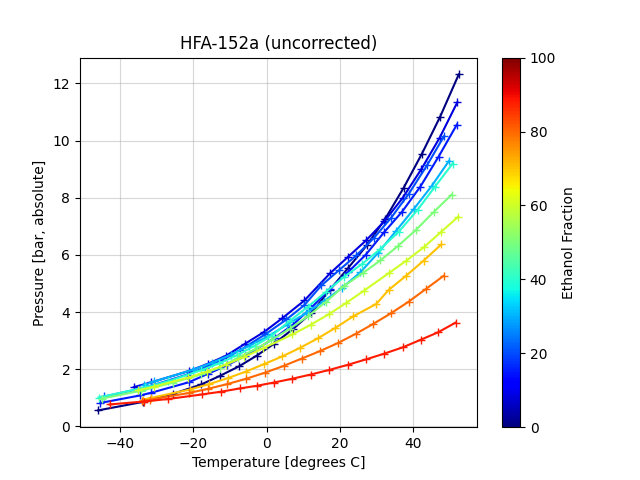

<IPython.core.display.Javascript object>


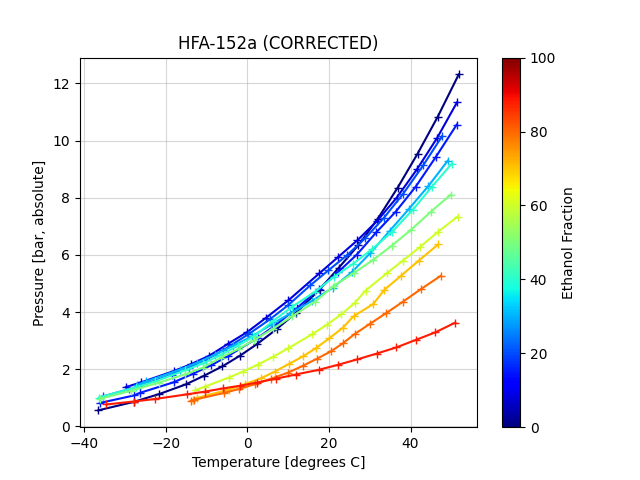

In [230]:
def line_plots(datasets, propellant=''):
    # Set up a colour scheme 
    cmap=plt.cm.jet
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=100))

    # Make figure uncorrected
    fig=plt.figure();plt.grid(alpha=.5)
    plt.xlabel("Temperature [degrees C]")
    plt.ylabel("Pressure [bar, absolute]")
    plt.title("%s (uncorrected)" % propellant)
    for dataset in datasets:
        plt.plot(dataset['Canister_Tcal_degC'], dataset['Pressure_bar_abs'],marker='+',\
                 c=cmap(dataset['EthanolFraction']/100.), label='%.1f%% Ethanol' % (dataset['EthanolFraction']))
    plt.colorbar(sm,label='Ethanol Fraction',ax=plt.gca());

    # Make figure corrected
    fig=plt.figure();plt.grid(alpha=.5)
    plt.xlabel("Temperature [degrees C]")
    plt.ylabel("Pressure [bar, absolute]")
    plt.title("%s (CORRECTED)" % propellant)
    for dataset in datasets:
        plt.plot(dataset['Canister_Tcal_degC']-dataset['Tcal_correction'], dataset['Pressure_bar_abs'],\
                 marker='+',\
                 c=cmap(dataset['EthanolFraction']/100.), label='%.1f%% Ethanol' % (dataset['EthanolFraction']))
    plt.colorbar(sm,label='Ethanol Fraction',ax=plt.gca());

line_plots(HFA152a_datasets,"HFA-152a")

### Make surface plot of pressure

<IPython.core.display.Javascript object>


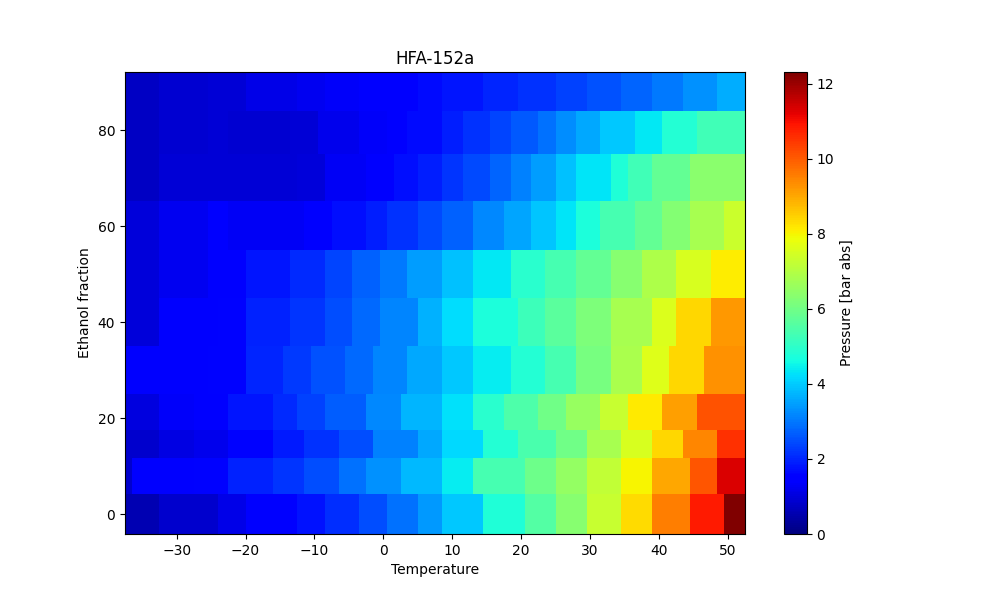

In [231]:
def make_surf(datasets,propellant='',corrected=True):
    
    # Get all data to 1D
    all_P = np.concatenate([ dataset['Pressure_bar_abs'] for dataset in datasets ])
    
    if corrected:
        all_T = np.concatenate([ dataset['Canister_Tcal_degC']-dataset['Tcal_correction'] for dataset in datasets ])
    else:
        all_T = np.concatenate([ dataset['Canister_Tcal_degC'] for dataset in datasets ])
    
    all_E = np.concatenate([ dataset['EthanolFraction']*np.ones_like(dataset['Pressure_bar_abs'])  for dataset in datasets ])

    # Make coordinate grid to interpolate onto.
    eth = [ dataset['EthanolFraction'] for dataset in datasets ]
    temp = np.unique(np.round(all_T,0)) # nearest degree C
    tt, ee = np.meshgrid(temp, eth)
    
    # Interpolate using Delaunay triangulation
    L1=scipy.interpolate.NearestNDInterpolator([(all_T[n], all_E[n]) for n in range(len(all_T))], all_P)
    pts = [(tt.ravel()[n], ee.ravel()[n]) for n in np.arange(np.product(ee.shape))]
    Pmap = L1(pts).reshape(ee.shape)

    # Make graph
    fig=plt.figure(figsize=(10,6))
    ph=plt.pcolormesh(tt,ee,Pmap,cmap=plt.cm.jet,vmin=0)
    plt.colorbar(ph,label="Pressure [bar abs]")
    plt.xlabel('Temperature')
    plt.ylabel('Ethanol fraction')
    plt.title(propellant);
    

make_surf(HFA152a_datasets, "HFA-152a")

## 4. Apply correction to HFO-1234ze(E) data

In [212]:
HFO1234ze_E8 = {'EthanolFraction':8, 'CorrectionParameters':popt2A,\
                'Canister_Tcal_degC':np.array([51.54911539,46.71524091,41.89159722,36.97505834,32.06446305,27.04029865,22.16333639,17.19771846,12.23877575,6.27139338,1.191234772,-5.919150745,-11.02842409,-16.11134997,-21.20153516,-31.40577569,-34.60862698,-45.92022197]),\
                'Pressure_bar_abs':np.array([9.190086994,8.125191935,7.167761719,6.283245867,5.595559583,5.046365249,4.459301077,3.864688275,3.350156456,2.820301846,2.416594651,1.953620348,1.662659978,1.382447503,1.183609183,0.868989486,0.788664867,0.564006698]),\
                'PressureTxTemp_degC':np.array([20.27921314,20.20882646,20.1906614,20.16164975,20.13280782,20.04000965,20.0548005,19.8773453,19.8764391,19.76010915,19.87898552,19.7160188,19.71748735,19.628199,19.58316705,19.79596755,19.79654526,20.08906611])}

HFO1234ze_E30 = {'EthanolFraction':30, 'CorrectionParameters':popt2G,\
                 'Canister_Tcal_degC':np.array([48.03927923,43.25778777,38.43679542,33.56732733,28.69306303,23.87346035,18.91709223,13.94559588,8.901815215,3.818092233,-1.331582627,-6.480168529,-11.60552466,-16.66330105,-21.64874291,-31.3098184,-33.19850955]),\
                 'Pressure_bar_abs':np.array([8.050724798,7.30767265,6.676566074,6.144365056,5.410216199,4.951320953,4.496189705,4.060396366,3.63249572,3.241242998,2.840927161,2.518969432,2.232375929,1.983356952,1.761006088,1.424487137,1.345964087]),\
                 'PressureTxTemp_degC':np.array([19.82629052,20.0712432,20.50563735,20.83623815,21.48710473,22.16107791,21.91240345,21.38407657,20.65640685,20.30965482,19.85916079,19.81818936,20.23351831,21.34246978,23.98259071,22.44379833,21.41360248])}

HFO1234ze_E40 = {'EthanolFraction':40, 'CorrectionParameters':popt2G,\
                 'Canister_Tcal_degC':np.array([46.77621003,46.67093847,42.07478715,37.29567802,32.38149239,27.58901288,22.81991423,18.02619638,13.17359431,8.06672455,3.106725095,-1.987913542,-7.039554859,-12.09335115,-17.13680373,-22.2631592,-32.41624461,-34.41803501]),\
                 'Pressure_bar_abs':np.array([7.200751743,7.093858719,6.598644703,6.031137055,5.488893681,5.048366563,4.646471864,4.251860819,3.87708763,3.47888852,3.146091808,2.820077914,2.499927216,2.247774188,2.030520051,1.822941271,1.483634371,1.384430206]),\
                 'PressureTxTemp_degC':np.array([20.87105827,19.68623521,20.63296276,20.37625042,19.7238259,20.47797413,20.67522121,21.11516894,21.40514063,19.82882765,19.40868605,19.46286143,19.58978189,19.31815678,19.37420816,19.44381612,19.52851004,19.3556819])}

HFO1234ze_E50 = {'EthanolFraction':50, 'CorrectionParameters':popt2G,\
                 'Canister_Tcal_degC':np.array([49.15582093,44.34547539,39.48982752,34.60938298,29.66268742,24.71762496,19.72836055,14.68915704,9.661820433,4.595732717,-0.503239004,-5.68762316,-10.88695387,-16.01949621,-21.24589507,-28.58617522,-34.35174023]),\
                 'Pressure_bar_abs':np.array([7.022254939,6.404162401,5.780270643,5.18178803,4.62150932,4.102373001,3.640796537,3.214756691,2.831833373,2.496736054,2.18892099,1.916133263,1.690332909,1.472876053,1.288561421,1.078339605,0.94068873]),\
                 'PressureTxTemp_degC':np.array([26.98560296,26.79568789,26.47609927,26.39574676,26.29932678,25.94999734,25.71491184,25.60123794,25.49540584,25.57047604,25.30955658,25.35102948,25.26103586,25.17687419,24.98900483,24.70691339,24.10984112])}

HFO1234ze_E60 = {'EthanolFraction':60, 'CorrectionParameters':popt2G,\
                 'Canister_Tcal_degC':np.array([45.76111156,41.33088502,36.65650743,31.94357171,27.08905517,22.16460178,17.53220596,12.63376261,7.817155521,3.127219151,-1.495344182,-6.208802557,-11.38113183,-16.15328331,-21.08661403]),\
                 'Pressure_bar_abs':np.array([6.360645593,5.796877179,5.238557715,4.71477174,4.222336717,3.761228988,3.355285667,2.977514028,2.6369674,2.334505091,2.059976315,1.815087111,1.59394983,1.413232919,1.250508927]),\
                 'PressureTxTemp_degC':np.array([25.10374065,24.89842331,24.69125259,24.49702037,24.22712125,22.37685826,22.15483162,21.89508912,22.12314746,22.48265186,22.7924496,23.23359249,24.57040751,25.45745189,26.53856236])}

HFO1234ze_E70 = {'EthanolFraction':70, 'CorrectionParameters':popt2G,\
                 'Canister_Tcal_degC':np.array([48.87532409,44.04789682,39.21033691,34.32739478,29.43948419,24.5001058,19.54466231,14.57437837,9.527114383,4.590227935,-0.305339782,-5.839016181,-10.99605942,-15.54253743,-21.50641815,-31.8960596,-34.83896371]),\
                 'Pressure_bar_abs':np.array([5.108935126,4.646845985,4.212087634,3.805032451,3.428573609,3.076251495,2.757115423,2.464416301,2.188953591,1.952030744,1.738068234,1.53026003,1.355104327,1.222719612,1.073692625,0.870460806,0.822513887]),\
                 'PressureTxTemp_degC':np.array([23.74881668,23.64718079,23.59132662,23.52320582,23.50376142,23.55032212,23.57373577,23.57534309,23.5986246,23.5768252,23.51712329,23.5500258,23.54494493,23.04608719,23.03013251,23.40911664,23.92139301])}


HFO1234ze_E80 = {'EthanolFraction':80, 'CorrectionParameters':popt2A,\
                 'Canister_Tcal_degC':np.array([50.95741797,46.15901881,41.23915778,36.36799135,31.35940688,26.53656379,21.43434583,16.51860972,11.56194222,6.350207717,1.21430639,-3.448631642,-8.530779299,-13.45224443,-18.39295064,-27.1500045,-34.49948295,-44.04645941]),\
                 'Pressure_bar_abs':np.array([3.571220576,3.343226869,3.071381216,2.732577389,2.535283468,2.325027167,2.134377337,1.968040748,1.815000516,1.685710145,1.548495491,1.440445868,1.331185455,1.240750128,1.161546315,1.033487411,0.946476688,0.850798259]),\
                 'PressureTxTemp_degC':np.array([18.54692812,19.19029218,19.49483511,19.42965125,19.42419517,19.3849772,19.12034126,19.336203,19.48381115,19.51256672,19.42239983,19.92290266,20.23830998,19.47025507,19.67786938,19.98552246,20.03075158,20.0048817])}

HFO1234ze_E90 = {'EthanolFraction':90, 'CorrectionParameters':popt2A,\
                 'Canister_Tcal_degC':np.array([52.33328385,47.37806698,42.4872981,37.57803171,32.61261566,27.65789364,22.53522848,17.5887927,12.36343072,7.29713854,2.139615204,-2.398182565,-7.777381165,-12.65817957,-17.72784147,-27.63418758,-34.5246928,-46.01880165]),\
                 'Pressure_bar_abs':np.array([2.436422105,2.233205436,2.041765438,1.848778988,1.696867467,1.563054065,1.441316126,1.333219734,1.223891759,1.123077884,1.040586887,0.960477627,0.893038843,0.81129259,0.74201126,0.636023776,0.585173132,0.513836831]),\
                 'PressureTxTemp_degC':np.array([19.53919384,18.47087621,19.39007205,19.55548136,19.40630532,19.42694609,19.53505308,19.62988968,19.16325308,19.15107421,19.1806218,19.28370998,19.37384759,19.3546604,19.28591847,19.42752413,19.38509517,19.58167604])}

### Make corrections for HFO-1234ze

In [232]:
# Put these in manually:
HFO1234_E0A['CorrectionParameters'] = popt1A
HFO1234_E0G['CorrectionParameters'] = popt1G

HFO1234ze_datasets = (HFO1234_E0A, HFO1234ze_E8, HFO1234ze_E30, HFO1234ze_E40, HFO1234ze_E50, HFO1234ze_E60,\
                      HFO1234ze_E70, HFO1234ze_E80, HFO1234ze_E90 )

# Loop all data sets, and apply correction & save it.
for dataset in HFO1234ze_datasets:
    
    Tdiff = dataset['Canister_Tcal_degC']-dataset['PressureTxTemp_degC']
    correction = temperatureCorrectionFunction(Tdiff, *dataset['CorrectionParameters'])
    dataset['Tcal_correction'] = correction

Plot results

<IPython.core.display.Javascript object>


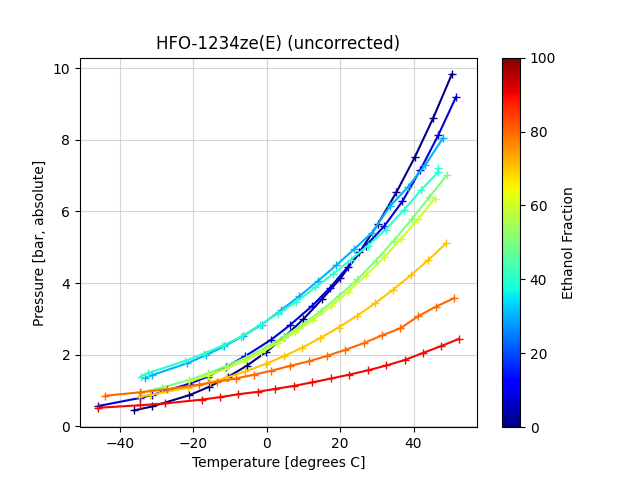

<IPython.core.display.Javascript object>


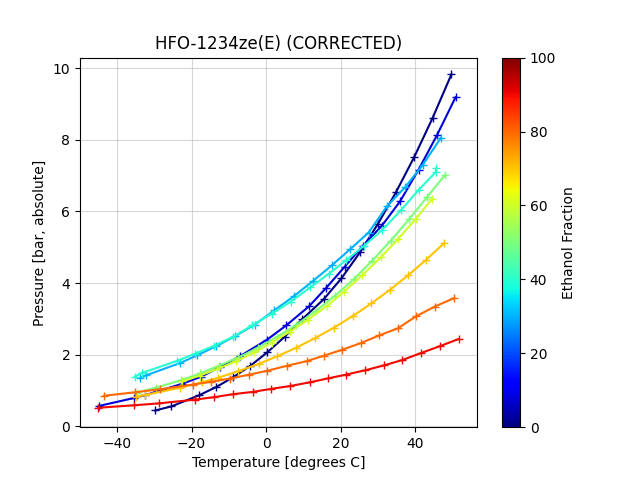

<IPython.core.display.Javascript object>


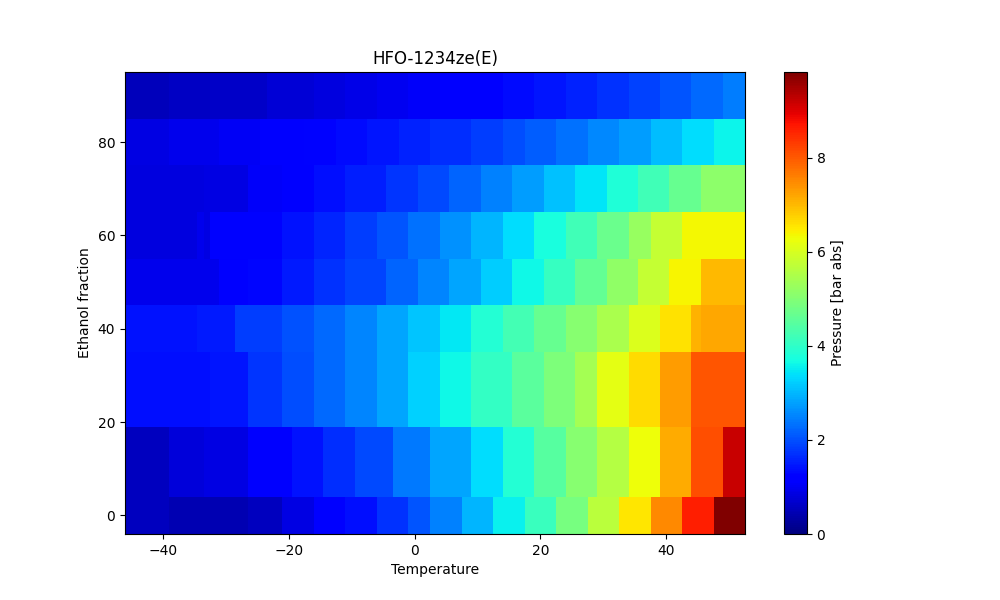

In [233]:
line_plots(HFO1234ze_datasets, "HFO-1234ze(E)")
make_surf(HFO1234ze_datasets, "HFO-1234ze(E)")

## 5. Apply correction HFA-134a data 
Using older data from DDL.

In [215]:
HFA134a_E8 = {'EthanolFraction':8, 'CorrectionParameters':popt3,\
              'Canister_Tcal_degC':np.array([52.075,48.144,44.300,40.123,36.266,32.213,28.058,26.930,21.472,21.803,18.785,15.951,12.379,9.713,6.082,1.835]),\
              'Pressure_bar_abs':np.array([11.946,10.869,9.905,9.004,8.306,7.634,7.024,6.792,6.069,5.874,5.510,5.190,4.792,4.344,3.897,3.457]),\
              'PressureTxTemp_degC':np.array([20.798,20.826,20.853,20.884,20.769,20.690,20.739,20.328,19.759,19.613,20.432,19.044,20.671,19.910,19.837,19.331])}

# More data required #

### Make corrections for HFA-134a

In [216]:
# Put these in manually:
HFA134a_E0['CorrectionParameters'] = popt3

HFA134a_datasets = (HFA134a_E0, HFA134a_E8)

# Loop all data sets, and apply correction & save it.
for dataset in HFA134a_datasets:
    
    Tdiff = dataset['Canister_Tcal_degC']-dataset['PressureTxTemp_degC']
    correction = temperatureCorrectionFunction(Tdiff, *dataset['CorrectionParameters'])
    dataset['Tcal_correction'] = correction

Plot results

<IPython.core.display.Javascript object>


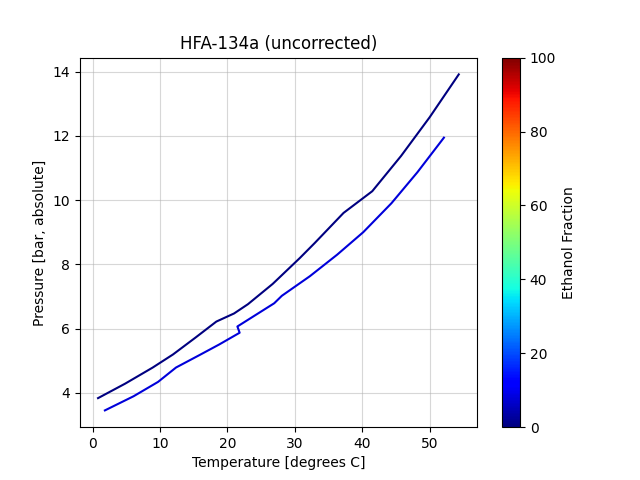

<IPython.core.display.Javascript object>


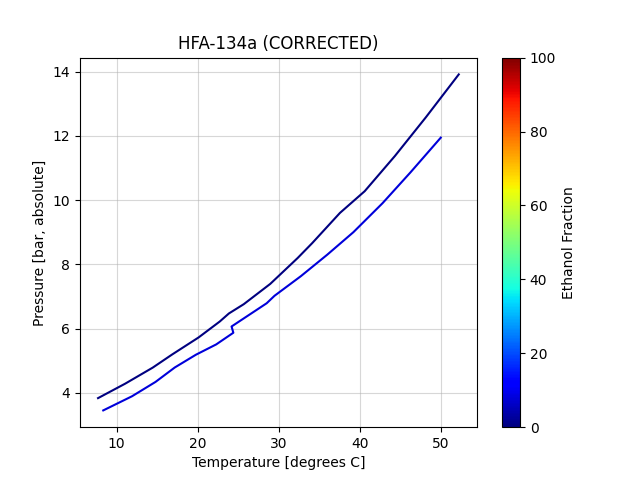

In [218]:
line_plots(HFA134a_datasets,"HFA-134a");
#make_surf(HFA134a_datasets,"HFA-134a");